<a href="https://colab.research.google.com/github/farrelrassya/teachingMLDL/blob/main/01.%20Machine%20Learning/11.%20Week%2011/Notebook/02.IntroductionToCNN%3AMNIST_Datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ==========================
# 1. Import dan Setup
# ==========================
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Visualisasi tambahan
import collections

# Untuk mengurangi pesan warning dari seaborn/matplotlib
import warnings
warnings.filterwarnings("ignore")

# Cek apakah GPU tersedia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device yang digunakan: {device}")

Device yang digunakan: cpu


In [2]:
# ==========================
# 2. Persiapan Data
# ==========================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Normalisasi MNIST
])

batch_size = 128  # Meningkatkan batch size untuk mempercepat pelatihan

train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                           download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                          download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 42.1MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.24MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.6MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.06MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
# ==========================
# 3. Definisi Model yang Disederhanakan
# ==========================
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Convolutional Layer 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Convolutional Layer 2
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)

        # Fully Connected Layer
        self.fc1 = nn.Linear(32 * 7 * 7, 64)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.pool1(out)

        out = self.conv2(out)
        out = self.relu2(out)
        out = self.pool2(out)

        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu3(out)
        out = self.fc2(out)
        return out

model = SimpleCNN().to(device)
print(model)

SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=64, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)


In [4]:
# ==========================
# 4. Definisi Hooks untuk Visualisasi
# ==========================
# Dictionary untuk menyimpan aktivasi dan gradien
activations = collections.defaultdict(list)
gradients = collections.defaultdict(list)

def get_activation(name):
    def hook(model, input, output):
        activations[name].append(output.detach())
    return hook

def get_gradient(name):
    def hook(model, grad_input, grad_output):
        gradients[name].append(grad_output[0].detach())
    return hook

# Mendaftarkan hooks
for name, layer in model.named_modules():
    if isinstance(layer, nn.ReLU) or isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
        layer.register_forward_hook(get_activation(name))
        layer.register_backward_hook(get_gradient(name))

In [5]:
# ==========================
# 5. Definisi Loss dan Optimizer
# ==========================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
# ==========================
# 6. Pelatihan Model
# ==========================
num_epochs = 5  # Mengurangi jumlah epoch untuk mempercepat pelatihan
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward dan optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Evaluasi pada data pengujian
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_test_loss = test_loss / len(test_loader.dataset)
    epoch_test_acc = 100 * correct_test / total_test
    test_losses.append(epoch_test_loss)
    test_accuracies.append(epoch_test_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, "
          f"Test Loss: {epoch_test_loss:.4f}, Test Acc: {epoch_test_acc:.2f}%")

Epoch [1/5], Train Loss: 0.2385, Train Acc: 93.26%, Test Loss: 0.0698, Test Acc: 97.87%
Epoch [2/5], Train Loss: 0.0645, Train Acc: 98.01%, Test Loss: 0.0469, Test Acc: 98.39%
Epoch [3/5], Train Loss: 0.0456, Train Acc: 98.59%, Test Loss: 0.0384, Test Acc: 98.70%
Epoch [4/5], Train Loss: 0.0352, Train Acc: 98.93%, Test Loss: 0.0328, Test Acc: 98.89%
Epoch [5/5], Train Loss: 0.0281, Train Acc: 99.14%, Test Loss: 0.0330, Test Acc: 98.85%


In [7]:
# ==========================
# Evaluasi Model dan Kumpulkan Prediksi
# ==========================
def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds

In [8]:
# ==========================
# Evaluasi Setelah Pelatihan
# ==========================
all_labels, all_preds = evaluate_model(model, test_loader, device)

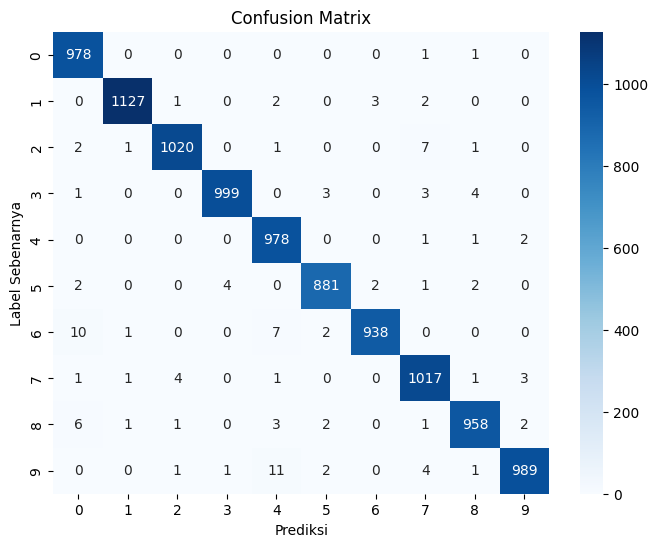

In [9]:
# ==========================
# 8. Confusion Matrix
# ==========================
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[str(i) for i in range(10)],
            yticklabels=[str(i) for i in range(10)])
plt.xlabel('Prediksi')
plt.ylabel('Label Sebenarnya')
plt.title('Confusion Matrix')
plt.show()

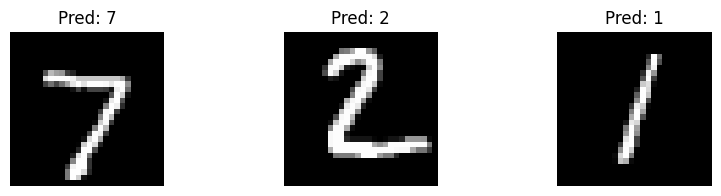

In [19]:
# ==========================
# 9. Menampilkan Beberapa Prediksi
# ==========================
model.eval()
examples = 3
with torch.no_grad():
    dataiter = iter(test_loader)
    images, labels = next(dataiter)  # Perbaiki di sini
    images = images.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    images = images.cpu().numpy()

    plt.figure(figsize=(10, 2))
    for idx in range(examples):
        plt.subplot(1, examples, idx+1)
        plt.imshow(np.squeeze(images[idx]), cmap='gray')
        plt.title(f"Pred: {predicted[idx].item()}")
        plt.axis('off')
    plt.show()

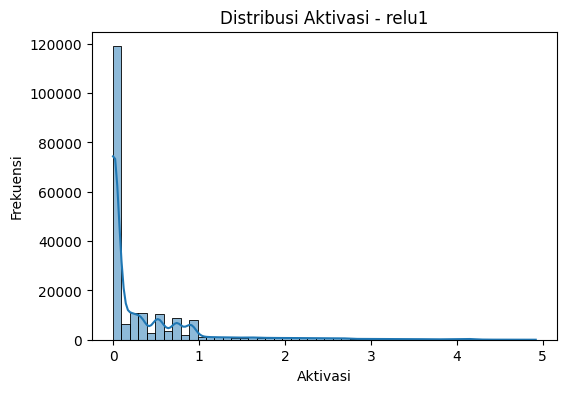

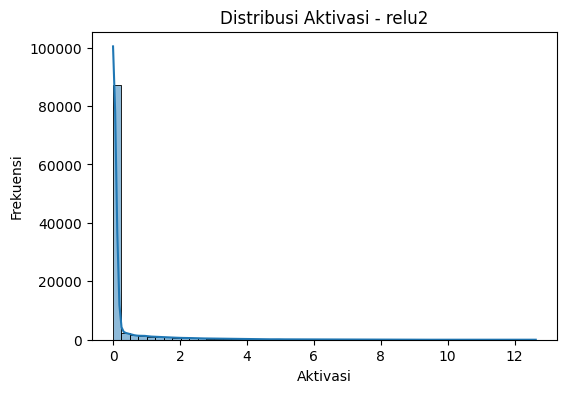

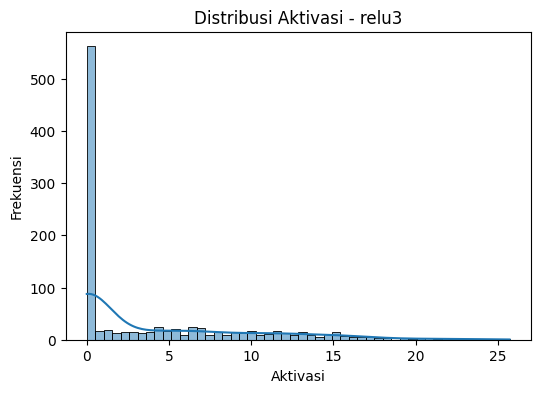

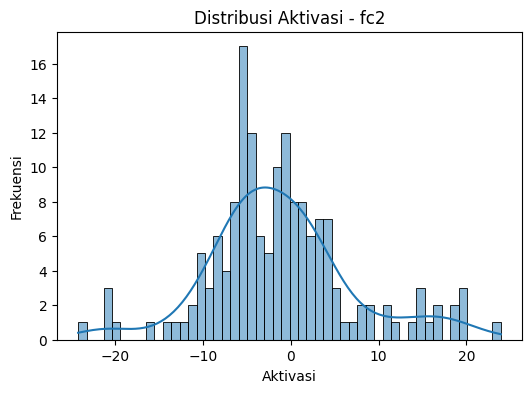

In [12]:
# ==========================
# 10. Visualisasi Distribusi Aktivasi
# ==========================
def plot_activation_distribution(activations, layer_name):
    act = activations[layer_name][-1].cpu().numpy()
    act = act.flatten()
    plt.figure(figsize=(6,4))
    sns.histplot(act, bins=50, kde=True)
    plt.title(f'Distribusi Aktivasi - {layer_name}')
    plt.xlabel('Aktivasi')
    plt.ylabel('Frekuensi')
    plt.show()

# Contoh untuk beberapa lapisan
layers_to_plot = ['relu1', 'relu2', 'relu3', 'fc2']
for layer in layers_to_plot:
    if layer in activations:
        plot_activation_distribution(activations, layer)

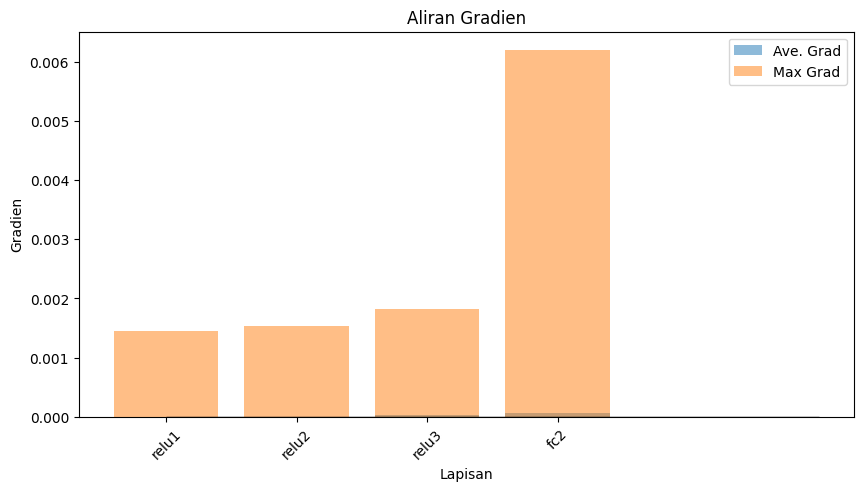

In [13]:
# ==========================
# 11. Visualisasi Aliran Gradien (Gradient Flow)
# ==========================
def plot_gradient_flow(gradients, layer_names):
    ave_grads = []
    max_grads = []
    for layer in layer_names:
        if layer in gradients:
            grads = gradients[layer]
            ave_grads.append(torch.mean(torch.stack([g.abs().mean() for g in grads])).item())
            max_grads.append(torch.stack([g.abs().max() for g in grads]).mean().item())

    plt.figure(figsize=(10,5))
    plt.bar(np.arange(len(layer_names)), ave_grads, alpha=0.5, label='Ave. Grad')
    plt.bar(np.arange(len(layer_names)), max_grads, alpha=0.5, label='Max Grad')
    plt.hlines(0, 0, len(layer_names)+1, linewidth=1, color="k" )
    plt.xticks(range(len(layer_names)), layer_names, rotation=45)
    plt.xlabel('Lapisan')
    plt.ylabel('Gradien')
    plt.title('Aliran Gradien')
    plt.legend()
    plt.show()

# Contoh untuk beberapa lapisan
layers_to_plot = ['relu1', 'relu2', 'relu3', 'fc2']
plot_gradient_flow(gradients, layers_to_plot)

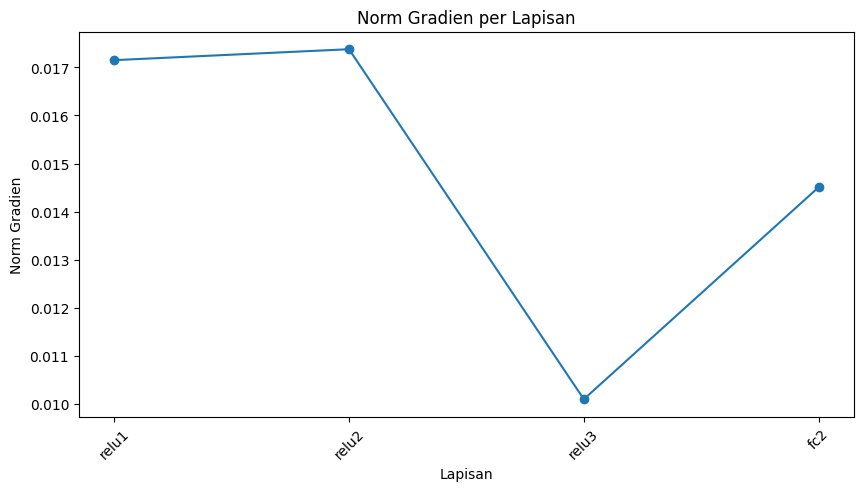

In [14]:
# ==========================
# 12. Visualisasi Norm Gradien
# ==========================
def plot_gradient_norm(gradients, layer_names):
    norm_grads = []
    for layer in layer_names:
        if layer in gradients:
            grads = gradients[layer]
            norm = torch.stack([g.norm() for g in grads]).mean().item()
            norm_grads.append(norm)

    plt.figure(figsize=(10,5))
    plt.plot(layer_names, norm_grads, 'o-')
    plt.title('Norm Gradien per Lapisan')
    plt.xlabel('Lapisan')
    plt.ylabel('Norm Gradien')
    plt.xticks(rotation=45)
    plt.show()

# Contoh untuk beberapa lapisan
layers_to_plot = ['relu1', 'relu2', 'relu3', 'fc2']
plot_gradient_norm(gradients, layers_to_plot)

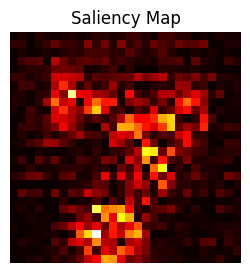

In [23]:
# ==========================
# 13. Visualisasi Peta Saliency (Saliency Map)
# ==========================
def plot_saliency_map(model, image, label, device):
    image = image.to(device)
    image.requires_grad = True

    model.eval()
    output = model(image.unsqueeze(0))
    loss = criterion(output, torch.tensor([label]).to(device))
    model.zero_grad()
    loss.backward()

    saliency, _ = torch.max(image.grad.data.abs(), dim=0)
    saliency = saliency.cpu().numpy()

    plt.figure(figsize=(3,3))
    plt.imshow(saliency, cmap='hot')
    plt.title('Saliency Map')
    plt.axis('off')
    plt.show()
model.eval()
examples = 1
with torch.no_grad():
    dataiter = iter(test_loader)
    images, labels = next(dataiter)  # Perbaiki di sini
for i in range(examples):
        plot_saliency_map(model, images[i], labels[i].item(), device)

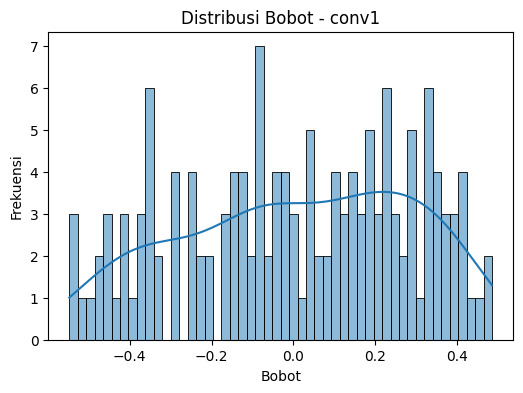

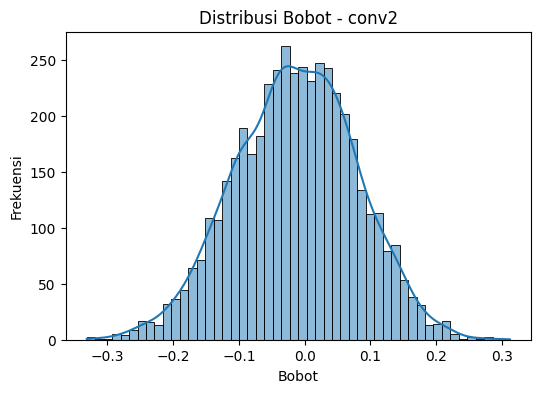

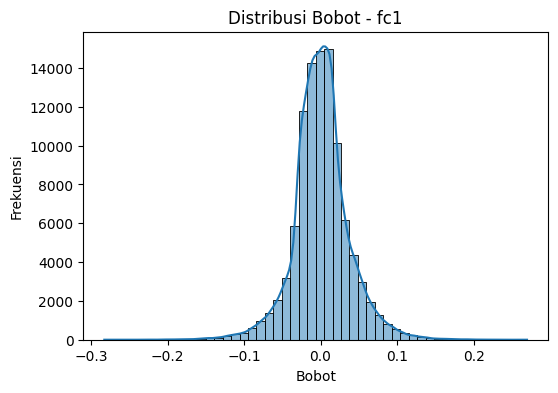

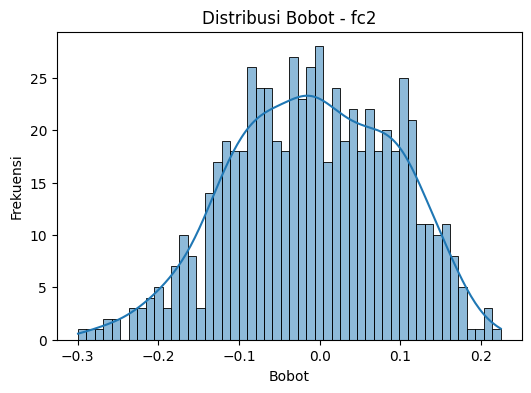

In [16]:
# ==========================
# 14. Visualisasi Distribusi Bobot (Weight Distribution)
# ==========================
def plot_weight_distribution(model, layer_names):
    for name, layer in model.named_modules():
        if name in layer_names and (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)):
            weights = layer.weight.data.cpu().numpy().flatten()
            plt.figure(figsize=(6,4))
            sns.histplot(weights, bins=50, kde=True)
            plt.title(f'Distribusi Bobot - {name}')
            plt.xlabel('Bobot')
            plt.ylabel('Frekuensi')
            plt.show()

# Contoh untuk beberapa lapisan
layers_to_plot = ['conv1', 'conv2', 'fc1', 'fc2']
plot_weight_distribution(model, layers_to_plot)